# Tensile Strength Ratio

In [1]:
#%% IMPORTS
#BASICS
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import absolute
from pandas.plotting import scatter_matrix
from sklearn.pipeline import make_pipeline
from IPython.display import display, Markdown, Latex
pd.options.display.max_columns = None

#STATISTICS
from scipy.stats import normaltest
from scipy import stats

#ML TRAINING AND DATA PREPROCESSING
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import PolynomialFeatures

#ML MODELS
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from xgboost import plot_importance

#MODEL EVALUATION
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold

#METRICS
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## 1. Methods

In [2]:
#Eliminate Outliers based on the interquantile
#datFrame: Data frame where the outliers will be eliminated.
#columnName: the name of the column where the outliers will be identified.
def eliminateOutliers (dataFrame, columnName):
    Q1 = dataFrame[columnName].quantile(0.25)
    Q3 = dataFrame[columnName].quantile(0.75)
    IQR = Q3 - Q1
    print('Initial dataframe size: '+str(dataFrame.shape))
    dataFrame = dataFrame[(dataFrame[columnName] < (Q3 + 1.5 * IQR)) & (dataFrame[columnName] > (Q1 - 1.5 * IQR))]
    print('Final dataframe size: '+str(dataFrame.shape))
    return dataFrame

In [3]:
# Create the boxplot graphs for the categorical variables
# dataFrame: Data frame associated to the property of interest (dfAirVoids, dfMS, dfMF, dfITS, dfTSR)
# propertyOfInterest: the name of the column where the property of interest is located.
# columnName1...4: The categorical columns to evaluate.
def displayBoxPlotGraphs (dataFrame, propertyOfInterest, columnName1, columnName2, columnName3, columnName4):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
    sns.boxplot(y = propertyOfInterest, x = columnName1, data=dataFrame,  orient='v' , ax=ax1)
    sns.boxplot(y = propertyOfInterest, x = columnName2, data=dataFrame,  orient='v' , ax=ax2)
    sns.boxplot(y = propertyOfInterest, x= columnName3, data=dataFrame,  orient='v' , ax=ax3)
    sns.boxplot(y= propertyOfInterest, x= columnName4, data=dataFrame,  orient='v' , ax=ax4)

## 2. Data Import

In [4]:
#%%DATA READING AND INITIAL PREPROCESSING
numericColumns = ['Aggregate absorption (%)',
                  'Apparent specific gravity',
                    0.075,
                    0.3,
                    0.6,
                    2.36,
                    4.75,
                    9.5,
                    12.5,
                    19,
                    'Plastic particle size (mm)',
                    'Mixing speed (RPM)',
                    'Mixing Temperature',
                    'Mixing Time (hours)',
                    'Plastic Addition by bitumen weight (%)',
                    'Bitumen content in the sample'
                    ]
categoricalColumns = ['Modified asphalt Mix?',
                      'Agreggate Type',
                    'Aggregate absorption (%)',
                    'Filler used',
                    'Consolidated bitumen penetration grade',
                    'New Plastic Type',
                    'Plastic pretreatment',
                    'Plastic shape',
                    'Plastic Size',
                    'Mixing Process',
                    'Plastic melted previous to addition?',
                    'Aggregates replacement ?',
                    'Bitumen replacement?',
                    'Filler replacement',
                    'Property',
                    'Units']
#It returns the dataframe of interes based on the property - 'AirVoids', 'MS', 'MF', 'ITS', 'TSR'
def returnDf (propertyOfInterest):
    df = pd.read_excel('fileML.xlsx', sheet_name = propertyOfInterest, engine='openpyxl')
    df = df.set_index(propertyOfInterest + ' ID')
    df.loc[:,:'Units'] = df.loc[:,:'Units'].applymap(str)
    df.loc[:,:'Units'] = df.loc[:,:'Units'] .applymap(str.strip)
    df.replace('NS', np.nan, inplace = True)
    df[numericColumns] = df[numericColumns].replace('N/a', 0).astype(float)
    return df

In [ ]:
dfTSR = returnDf('TSR')

## 3. Data Exploration
###  3.1 Total Sample

In [ ]:
dfTSR = eliminateOutliers(dfTSR, 'TSR of the sample[%]')

In [ ]:
scatter_matrix(dfTSR[['Aggregate absorption (%)', 'Apparent specific gravity', 'Bitumen content in the sample', 'TSR of the sample[%]']], figsize=(10, 10))
plt.show()

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfTSR.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap TSR', fontdict={'fontsize':12}, pad=12)

Positive correlation with $\color{red}{\text{gradiation}}$ and negative with $\color{red}{\text{Aggregate absorption}}$.

In [ ]:
displayBoxPlotGraphs(dataFrame = dfTSR, propertyOfInterest = 'TSR of the sample[%]', columnName1 = "Agreggate Type", columnName2 = "Filler used", columnName3 = "Consolidated bitumen penetration grade", columnName4 = "Modified asphalt Mix?")

It exists an strong difference between modified and unmodified asphalt mixture.

###  3.2 Modified mixtures

In [ ]:
dfTSRModvsUnmod = dfTSR [['Modified asphalt Mix?', 'TSR of the sample[%]']]
dfTSRModvsUnmod.groupby(['Modified asphalt Mix?'], as_index=False).describe()

In [ ]:
dfTSRModified = dfTSR[dfTSR['Modified asphalt Mix?'] == 'Yes']
dfTSRModified.iloc[:,2:].describe(include = "all")

In [ ]:
columnsOfInteres = numericColumns[0:2]+numericColumns[10:]+['TSR of the sample[%]']
scatter_matrix(dfTSRModified[columnsOfInteres], figsize=(25, 20))
plt.show()

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfTSRModified.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap TSR', fontdict={'fontsize':12}, pad=12)

In [ ]:
displayBoxPlotGraphs(dataFrame = dfTSRModified, propertyOfInterest = "TSR of the sample[%]", columnName1 = "Agreggate Type", columnName2 = "Plastic shape", columnName3 = "New Plastic Type", columnName4 = "Mixing Process")

The large correlation is with $\color{red}{\text{plastic addition quantity}}$, and it exists a significant difference between $\color{red}{\text{wet}}$ and $\color{red}{\text{dry}}$ mixing.

### 3.3 Wet vs. Dry Mixing

In [ ]:
dfTSRWetvsDry = dfTSRModified [['Mixing Process', 'TSR of the sample[%]']]
dfTSRWetvsDry.groupby(['Mixing Process'], as_index=False).describe()

In [ ]:
sns.pairplot(dfTSRModified[columnsOfInteres+['Mixing Process']], hue="Mixing Process", height=2.5)

##  **TSR summary:**

 *  1 outliers were eliminated from the original sample.
 *  Total number of observation: 146 -> $\mu$ = 84, $\sigma$ = 10.31.
 *  Highest positive correlation with $\color{red}{\text{gradation}}$, and it exists a negative correlation with $\color{red}{\text{aggregate absorptionn}}$ (r = -0.18)
 *  Some difference between the modified and unmodified mixtures -> $\mu_{modified}$ = 86.48,  $\mu_{unmodified}$ = 77.65.
 *  Modified mixtures present positive correlation with $\color{red}{\text{plastic addition}}$ (r = 0.26).
 *  Possible difference between dry and wet.  Dry ($\mu_{dry}$ = 88, $\sigma_{dry}$ = 8.9) vs. wet ($\mu_{wet}$ = 83.7, $\sigma_{wet}$ = 8.3) -> This is not conclusive because the variance of both sample groups is large.

## 4. Data Pre-processing

In [ ]:
dfTSR.info()

###  Pre-processing:
1.  Eliminate the columns $\color{red}{\text{Article ID}}$, $\color{red}{\text{Global ID}}$, $\color{red}{\text{Aggregate type}}$, $\color{red}{\text{Apparent specific gravity}}$, $\color{red}{\text{filler used}}$, $\color{red}{\text{Bitumen type penetration grade}}$, $\color{red}{\text{plastic size}}$, $\color{red}{\text{Property}}$ and $\color{red}{\text{Units}}$.
2.  Change the N/a to zero. This is for the unmodified mixtures.
4.  Change categorical columns to numeric - $\color{red}{\text{Modified asphalt Mix?}}$, $\color{red}{\text{Consolidated bitumen penetration grade}}$, $\color{red}{\text{New Plastic Type}}$, $\color{red}{\text{Plastic pretreatment}}$, $\color{red}{\text{Plastic shape}}$, $\color{red}{\text{Mixing Process}}$, $\color{red}{\text{Plastic melted previous to addition?}}$, $\color{red}{\text{Replacements}}$.
5.  Imputer to $\color{red}{\text{Aggregate absorption}}$, $\color{red}{\text{gradations}}$, $\color{red}{\text{plastic size(mm)}}$, $\color{red}{\text{mixing parameters}}$ and $\color{red}{\text{Bitumen content in the sample}}$.

In [35]:
dfTSRCleaned = dfTSR.drop(['Article ID', 
                        'Global ID',
                        'Modified asphalt Mix?',
                        'Agreggate Type', 
                        'Apparent specific gravity', 
                        'Filler used', 
                        'Bitumen Type Penetration Grade',
                        'Plastic Size', 
                        'Property', 
                        'Units'], axis = 1)
dfTSRCleaned = dfTSRCleaned.replace('N/a', 0)
dfTSRCleaned = pd.get_dummies(dfTSRCleaned, columns=['New Plastic Type'], drop_first = False)
dfTSRCleaned = pd.get_dummies(dfTSRCleaned, drop_first=True)
dfTSRCleaned = dfTSRCleaned.drop(['New Plastic Type_0'], axis = 1)
dfTSRCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146 entries, 35 to 16
Data columns (total 32 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Aggregate absorption (%)                       108 non-null    float64
 1   0.075                                          139 non-null    float64
 2   0.3                                            139 non-null    float64
 3   0.6                                            143 non-null    float64
 4   2.36                                           143 non-null    float64
 5   4.75                                           143 non-null    float64
 6   9.5                                            143 non-null    float64
 7   12.5                                           143 non-null    float64
 8   19                                             143 non-null    float64
 9   Plastic particle size (mm)                     113 non

In [36]:
#IMPUTATION OF MISSING VALUES
imputer = IterativeImputer (estimator = ExtraTreesRegressor(n_estimators=10, random_state=0), max_iter=100)
n = imputer.fit_transform(dfTSRCleaned)
dfTSRCleanedImputed = pd.DataFrame(n, columns = list(dfTSRCleaned.columns))
dfTSRCleanedImputed.info()
print ('There is '+str(sum(n < 0 for n in dfTSRCleanedImputed.values.flatten()))+' negative values in the new Dataframe')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 32 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Aggregate absorption (%)                       146 non-null    float64
 1   0.075                                          146 non-null    float64
 2   0.3                                            146 non-null    float64
 3   0.6                                            146 non-null    float64
 4   2.36                                           146 non-null    float64
 5   4.75                                           146 non-null    float64
 6   9.5                                            146 non-null    float64
 7   12.5                                           146 non-null    float64
 8   19                                             146 non-null    float64
 9   Plastic particle size (mm)                     146 non

In [37]:
dfTSRCleanedImputed['New Plastic Type_PE'] = dfTSRCleanedImputed['New Plastic Type_PE'] * dfTSRCleanedImputed['Plastic Addition by bitumen weight (%)']
dfTSRCleanedImputed['New Plastic Type_PET'] = dfTSRCleanedImputed['New Plastic Type_PET'] * dfTSRCleanedImputed['Plastic Addition by bitumen weight (%)']
dfTSRCleanedImputed['New Plastic Type_PP'] = dfTSRCleanedImputed['New Plastic Type_PP'] * dfTSRCleanedImputed['Plastic Addition by bitumen weight (%)']
dfTSRCleanedImputed['New Plastic Type_PS'] = dfTSRCleanedImputed['New Plastic Type_PS'] * dfTSRCleanedImputed['Plastic Addition by bitumen weight (%)']
dfTSRCleanedImputed['New Plastic Type_Plastic Mix'] = dfTSRCleanedImputed['New Plastic Type_Plastic Mix'] * dfTSRCleanedImputed['Plastic Addition by bitumen weight (%)']
dfTSRCleanedImputed = dfTSRCleanedImputed.drop(['Plastic Addition by bitumen weight (%)'], axis = 1)

In [38]:
scaler = MinMaxScaler()
dfTSRCleanedImputedScaled = pd.DataFrame(scaler.fit_transform(dfTSRCleanedImputed), columns = list(dfTSRCleanedImputed.columns))
dfTSRCleanedImputedScaled.to_clipboard()

## 5. Model Training

In [39]:
min = dfTSRCleanedImputed['TSR of the sample[%]'].min()
max = dfTSRCleanedImputed['TSR of the sample[%]'].max()
print('The min value is: '+str(min)+'. The max value is: '+str(max))

The min value is: 62.1. The max value is: 109.65


In [ ]:
#Method that print the best parameters, R2 and MSE based on a grid search.
def printBestModelAdv (grid, estimator = n, advancedAnalysis = False):
    min = dfTSRCleanedImputed['TSR of the sample[%]'].min()
    max = dfTSRCleanedImputed['TSR of the sample[%]'].max()
    mse = -grid.best_score_
    print('Best Parameters:' , grid.best_params_)
    print('Best Test MSE: ' + str(mse))
    print('Std of the Test MSE:' + str(grid.cv_results_['std_test_neg_mean_squared_error'][grid.best_index_]))
    print('Best Test RMSE: ' +str(math.sqrt(mse)))
    print('Best Test scaled RMSE: ' +str((math.sqrt(mse)*(max-min))+min))
    print('Best Test scaled MSE: ' +str(((math.sqrt(mse)*(max-min))+min)**2)) 
    print('Best Test R2: ' + str(grid.cv_results_['mean_test_r2'][grid.best_index_]))
    if (advancedAnalysis):
        bestEstimator = estimator
        bestEstimator.fit(X_train, y_train)
        predictionsTrain = bestEstimator.predict(X_train)
        df = pd.DataFrame({'predictions':predictionsTrain, 'original': y_train})
        df.plot.hist(bins=10, alpha=0.5)
        unScaledDf = (df*(max-min))+min
        print (unScaledDf.describe())

In [40]:
X = dfTSRCleanedImputedScaled.loc[:, dfTSRCleanedImputedScaled.columns != 'TSR of the sample[%]']
y = dfTSRCleanedImputedScaled.loc[:,'TSR of the sample[%]']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 123)

In [41]:
y_train_new = y_train.to_frame()
y_train_new['y_train_unscaled'] = (y_train*(max-min))+min
y_train_new.describe()

,TSR of the sample[%],y_train_unscaled
count,116.000000,116.000000
mean,0.487701,85.290172
std,0.208753,9.926213
min,0.011567,62.650000
25%,0.374711,79.917500
50%,0.500736,85.910000
75%,0.630074,92.060000
max,1.000000,109.650000


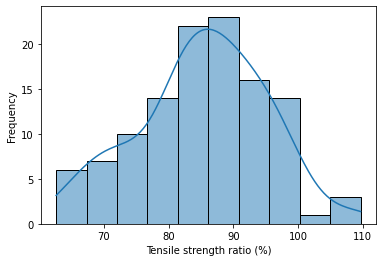

In [42]:
g = sns.histplot(data=y_train_new, x="y_train_unscaled", bins=10, kde=True)
g.set_ylabel('Frequency')
g.set_xlabel('Tensile strength ratio (%)')
plt.show()

In [ ]:
sns.set_style('darkgrid')
fig, ax = plt.subplots()
sns.histplot(x=y_train_new["y_train_unscaled"], bins=10, kde=True, ax = ax)
ax.set(xlabel='Tensile strength ratio (%)')
ax.axvline(x=70, label='Minimum accepted value' , linestyle = '--', color='k')
ax.set_title('(e)')
ax.legend()
plt.show()

In [ ]:
len(y_train_new[y_train_new["y_train_unscaled"]<70])

### 5.1 Model Evaluation
#### Linear Model

In [ ]:
param_grid = {'fit_intercept': [True, False],
            'positive': [True, False]}
grid = GridSearchCV(LinearRegression(), param_grid, cv = cv, scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X_train, y_train)
printBestModelAdv(grid) 

#### Lasso Linear Model

In [ ]:
param_grid = {'alpha': [0.001,1, 10, 15, 30, 50, 100],
            'fit_intercept':[True, False],
            'positive': [True, False]}
grid = GridSearchCV(Lasso(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Ridge Linear regression model

In [ ]:
param_grid = {'alpha': [7, 8, 10,100],
'fit_intercept': [True, False],
'solver': [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
grid = GridSearchCV(Ridge(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Linear Elastic net

In [ ]:
param_grid = {'alpha': [0.01,1,2,3,4],
'fit_intercept': [True, False]}
grid = GridSearchCV(ElasticNet(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Polynomial model

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
'linearregression__fit_intercept': [True, False],
'linearregression__positive':[True, False]}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Lasso Polynomial model

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Lasso(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
            'lasso__alpha': [1,2, 3, 10, 15, 30],
            'lasso__fit_intercept':[True, False],
            'lasso__positive': [True, False],
            'lasso__max_iter': [2000,3000, 3500]}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Ridge polynomial model

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Ridge(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
'ridge__alpha':[20,30,50, 60],
'ridge__fit_intercept': [True, False],
'ridge__solver': [ 'lsqr', 'cholesky', 'sparse_cg', 'auto']}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Support vector regression

In [ ]:
param_grid = {
    'kernel':['linear','rbf', 'sigmoid', 'poly'],
    'degree':[2,3,4],
    'C':[0.01,1,5,10],
    'epsilon':[0.1,0.2, 1, 1.5]
}
grid = GridSearchCV(SVR(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Decision Tree regressor

In [ ]:
param_grid = {
    'max_depth':[None,2,3,5,10,30,50],
    'min_samples_split':[2,3,4],
    'min_samples_leaf':[1,2,5],
    'max_leaf_nodes': [None, 5,10]
}
grid = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Random Forest

In [ ]:
param_grid = {
    'bootstrap': [False],
    'max_depth': [None],
    'max_features': [ 'sqrt'],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid, RandomForestRegressor(**grid.best_params_), True)

In [ ]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
grid = RandomizedSearchCV(RandomForestRegressor(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error', n_iter=10)
grid.fit(X_train, y_train)
printBestModelAdv(grid, RandomForestRegressor(**grid.best_params_), True)

#### Extra tree regressor

In [ ]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
grid = RandomizedSearchCV(ExtraTreesRegressor(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error', n_iter=10)
grid.fit(X_train, y_train)
printBestModelAdv(grid, RandomForestRegressor(**grid.best_params_), True)

#### XG Boost Regressor

In [ ]:
XGBoostModel = XGBRegressor()
scores = cross_val_score(XGBoostModel, X_train, y_train , scoring = 'neg_mean_squared_error', cv = cv)
scores = np.absolute(scores)
print (scores.mean())

In [ ]:
param_grid = {
    'eta':[0.07,0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5],
    'max_depth':np.arange(3,11,1),
    'max_delta_step': np.arange(0,11,1),
    'gamma' : [0, 0.001, 0.01, 0.1, 1, 10],
    'lambda' : np.arange(5,15,1),
    'alpha' : np.arange(0,11,1),
    'n_estimators': [100,300,500,1000]
}
grid = RandomizedSearchCV(XGBRegressor(random_state=123), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error',n_iter=10)
grid.fit(X_train, y_train)
printBestModelAdv(grid, XGBRegressor(**grid.best_params_), True)

In [ ]:
param_grid = {
    'n_estimators': [100,300, 500, 1000]
}
grid = GridSearchCV(XGBRegressor(random_state=123), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid, XGBRegressor(**grid.best_params_), True)

In [ ]:
#Graph employed for selecting important features during tunning
XGBoostModel.fit(X,y)
ax = plot_importance(XGBoostModel, height=0.8, importance_type='gain', show_values=False)
fig = ax.figure
fig.set_size_inches(10,10)

## 6. Best Model Tunning

In [43]:
X.columns = X.columns.astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
cv = RepeatedKFold(n_splits = 5, n_repeats = 15, random_state = 123)

### 6.1. Feature selection

In [ ]:
features_MSE = {}
def addMSE (columns, string):
    cv_results = cross_validate(XGBRegressor(random_state = 1), X_train[columns], y_train, cv = cv, scoring = ['neg_mean_squared_error'])
    MSE = np.average(-cv_results['test_neg_mean_squared_error'])
    features_MSE[string] = MSE

In [ ]:
X_train.columns

In [ ]:
addMSE(['Plastic shape_Fibers', 'Plastic shape_Pellets','Plastic shape_Shredded'], 
        'Plastic shape')

In [ ]:
addMSE(['Plastic shape_Fibers', 'Plastic shape_Pellets','Plastic shape_Shredded',
        'Plastic pretreatment_Physical', 'Plastic pretreatment_Plastic Melted'], 
        'Plastic shape \n Plastic pretreatment')

In [ ]:
addMSE(['Plastic shape_Fibers', 'Plastic shape_Pellets','Plastic shape_Shredded',
        'Plastic pretreatment_Physical', 'Plastic pretreatment_Plastic Melted',
         '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19'], 
        'Plastic shape \n Plastic pretreatment \n Gradation')

In [ ]:
addMSE(['Plastic shape_Fibers', 'Plastic shape_Pellets','Plastic shape_Shredded',
        'Plastic pretreatment_Physical', 'Plastic pretreatment_Plastic Melted',
        '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'New Plastic Type_PE','New Plastic Type_PET', 'New Plastic Type_PP', 'New Plastic Type_PS',
        'New Plastic Type_Plastic Mix'], 
        'Plastic shape \n Plastic pretreatment \n Gradation\n Plastic type')

In [ ]:
addMSE(['Plastic shape_Fibers', 'Plastic shape_Pellets','Plastic shape_Shredded',
        'Plastic pretreatment_Physical', 'Plastic pretreatment_Plastic Melted',
        '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'New Plastic Type_PE','New Plastic Type_PET', 'New Plastic Type_PP', 'New Plastic Type_PS',
        'New Plastic Type_Plastic Mix',
        'Consolidated bitumen penetration grade_50/70',
        'Consolidated bitumen penetration grade_70/100'], 
        'Plastic shape \n Plastic pretreatment \n Gradation\n Plastic type \n Bitumen type')

In [ ]:
addMSE(['Plastic shape_Fibers', 'Plastic shape_Pellets','Plastic shape_Shredded',
        'Plastic pretreatment_Physical', 'Plastic pretreatment_Plastic Melted',
        '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'New Plastic Type_PE','New Plastic Type_PET', 'New Plastic Type_PP', 'New Plastic Type_PS',
        'New Plastic Type_Plastic Mix',
        'Consolidated bitumen penetration grade_50/70',
        'Consolidated bitumen penetration grade_70/100',
        'Mixing speed (RPM)'], 
        'Plastic shape \n Plastic pretreatment \n Gradation\n Plastic type \n Bitumen type \n Mixing speed')

In [ ]:
addMSE(['Plastic shape_Fibers', 'Plastic shape_Pellets','Plastic shape_Shredded',
        'Plastic pretreatment_Physical', 'Plastic pretreatment_Plastic Melted',
        '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'New Plastic Type_PE','New Plastic Type_PET', 'New Plastic Type_PP', 'New Plastic Type_PS',
        'New Plastic Type_Plastic Mix',
        'Consolidated bitumen penetration grade_50/70',
        'Consolidated bitumen penetration grade_70/100',
        'Mixing speed (RPM)',
        'Plastic particle size (mm)'], 
        'Plastic shape \n Plastic pretreatment \n Gradation\n Plastic type \n Bitumen type \n Mixing speed \n Plastic size')

In [ ]:
addMSE(['Plastic shape_Fibers', 'Plastic shape_Pellets','Plastic shape_Shredded',
        'Plastic pretreatment_Physical', 'Plastic pretreatment_Plastic Melted',
        '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'New Plastic Type_PE','New Plastic Type_PET', 'New Plastic Type_PP', 'New Plastic Type_PS',
        'New Plastic Type_Plastic Mix',
        'Consolidated bitumen penetration grade_50/70',
        'Consolidated bitumen penetration grade_70/100',
        'Mixing speed (RPM)',
        'Plastic particle size (mm)',
        'Aggregate absorption (%)'], 
        'Plastic shape \n Plastic pretreatment \n Gradation\n Plastic type \n Bitumen type \n Mixing speed \n Plastic size \n Agg. absorption' )

In [ ]:
addMSE(['Aggregate absorption (%)', '0.075', '0.3', '0.6', '2.36', '4.75',
       '9.5', '12.5', '19', 'Plastic particle size (mm)', 'Mixing speed (RPM)',
       'Mixing Temperature', 'Mixing Time (hours)',
       'Bitumen content in the sample', 'New Plastic Type_PE',
       'New Plastic Type_PET', 'New Plastic Type_PP', 'New Plastic Type_PS',
       'New Plastic Type_Plastic Mix',
       'Consolidated bitumen penetration grade_50/70',
       'Consolidated bitumen penetration grade_70/100',
       'Plastic pretreatment_Physical', 'Plastic pretreatment_Plastic Melted',
       'Plastic shape_Fibers', 'Plastic shape_Pellets',
       'Plastic shape_Shredded', 'Mixing Process_Dry', 'Mixing Process_Wet',
       'Aggregates replacement ?_Yes', 'Bitumen replacement?_Yes'], 
        'Plastic shape \n Plastic pretreatment \n Gradation\n Plastic type \n Bitumen type \n Mixing speed \n Plastic size \n Agg. absorption \n Rest of features' )

In [ ]:
 plt.rcParams["figure.figsize"] = (20,5)
 plt.plot(features_MSE.keys(), features_MSE.values(), marker = '*') 
 plt.ylim(ymin = 0)
 plt.axvline(x='Plastic shape \n Plastic pretreatment \n Gradation\n Plastic type \n Bitumen type \n Mixing speed \n Plastic size', ymin=0, ymax=1, color = 'k', ls = '--' , label='Selected model')
 plt.ylabel('MSE', fontsize = 'xx-large')
 plt.xlabel('Features included in the model', fontsize = 'xx-large')
 plt.legend()
 plt.show()

The features most approppiate for the model are aggregates gradation, bitumen content, plastic type, plastic addition.
### 6.2 Model Tunning

In [44]:
X_train = X_train [['Plastic shape_Fibers', 'Plastic shape_Pellets','Plastic shape_Shredded',
        'Plastic pretreatment_Physical', 'Plastic pretreatment_Plastic Melted',
        '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'New Plastic Type_PE','New Plastic Type_PET', 'New Plastic Type_PP', 'New Plastic Type_PS',
        'New Plastic Type_Plastic Mix',
        'Consolidated bitumen penetration grade_50/70',
        'Consolidated bitumen penetration grade_70/100',
        'Mixing speed (RPM)',
        'Plastic particle size (mm)']]
X_test = X_test [['Plastic shape_Fibers', 'Plastic shape_Pellets','Plastic shape_Shredded',
        'Plastic pretreatment_Physical', 'Plastic pretreatment_Plastic Melted',
        '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'New Plastic Type_PE','New Plastic Type_PET', 'New Plastic Type_PP', 'New Plastic Type_PS',
        'New Plastic Type_Plastic Mix',
        'Consolidated bitumen penetration grade_50/70',
        'Consolidated bitumen penetration grade_70/100',
        'Mixing speed (RPM)',
        'Plastic particle size (mm)']]

In [ ]:
def tuning_evaluation (parameters, X, y):
    param_grid = parameters
    grid = GridSearchCV(XGBRegressor(random_state = 1), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')
    grid.fit(X, y)
    test_MSE = -grid.cv_results_['mean_test_neg_mean_squared_error'][grid.best_index_]
    test_r2 = grid.cv_results_['mean_test_r2'][grid.best_index_]
    best_param = grid.best_params_
    print ('r2 test: ' + str(test_r2))
    print ('MSE test: ' + str(test_MSE))
    print ('Best Parameters ' + str(best_param))

In [ ]:
param_grid = {
        'eta':[0.1, 0.2, 0.3, 0.4, 0.5]
    }
tuning_evaluation (param_grid, X_train, y_train)

In [ ]:
param_grid = {
        'eta':[0.1],
        'max_depth':np.arange(3,11,1)
    }
tuning_evaluation (param_grid, X_train, y_train)

In [ ]:
param_grid = {
        'eta':[0.1],
        'max_depth':[4],
        'min_child_weight':np.arange(1,11,1)
    }
tuning_evaluation (param_grid, X_train, y_train)

In [ ]:
param_grid = {
        'eta':[0.1],
        'max_depth':[4],
        'min_child_weight':[4],
        'max_delta_step': np.arange(0,11,1)
    }
tuning_evaluation (param_grid, X_train, y_train)

In [ ]:
param_grid = {
        'eta':[0.1],
        'max_depth':[4],
        'min_child_weight':[4],
        'max_delta_step': [0],
        'gamma' : [0, 0.001, 0.01, 0.1, 1, 10]
    }
tuning_evaluation (param_grid, X_train, y_train)

In [ ]:
param_grid = {
        'eta':[0.1],
        'max_depth':[4],
        'min_child_weight':[4],
        'max_delta_step': [0],
        'gamma' : [0],
        'subsample' : [1]
    }
tuning_evaluation (param_grid, X_train, y_train)

In [ ]:
param_grid = {
        'eta':[0.1],
        'max_depth':[4],
        'min_child_weight':[4],
        'max_delta_step': [0],
        'gamma' : [0],
        'subsample' : [1],
        'colsample_bytree':[0, 0.5 ,1],
        'colsample_bylevel':[0, 0.5 ,1],
        'colsample_bynode':[0, 0.5 ,1]
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

In [ ]:
param_grid = {
        'eta':[0.1],
        'max_depth':[4],
        'min_child_weight':[4],
        'max_delta_step': [0],
        'gamma' : [0],
        'subsample' : [1],
        'colsample_bytree':[0.5],
        'colsample_bylevel':[1],
        'colsample_bynode':[1],
        'lambda' : np.arange(1,10,1)
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

In [ ]:
param_grid = {
        'eta':[0.1],
        'max_depth':[4],
        'min_child_weight':[4],
        'max_delta_step': [0],
        'gamma' : [0],
        'subsample' : [1],
        'colsample_bytree':[0.5],
        'colsample_bylevel':[1],
        'colsample_bynode':[1],
        'lambda' : [2],
        'alpha' : np.arange(0,11,1)
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

### 6.3 Final model evaluation on test set

In [45]:
XGModel = XGBRegressor(random_state=123)
XGModel.fit(X_train, y_train)
predictions_test = XGModel.predict(X_test)
r2_test = r2_score(y_test, predictions_test)
mse_test = mean_squared_error(y_test, predictions_test)
print('The test r2 is: ' + str(r2_test))
print('The test MSE is: ' + str(mse_test))
predictions_train = XGModel.predict(X_train)
r2_train = r2_score(y_train, predictions_train)
mse_train = mean_squared_error(y_train, predictions_train)
print('The train r2 is: ' + str(r2_train))
print('The train MSE is: ' + str(mse_train))

The test r2 is: 0.7805412396269895
The test MSE is: 0.012714032266303292
The train r2 is: 0.9648354257676679
The train MSE is: 0.0015191874328936762


In [48]:
def modelEvaluation (model, Title):
    #Model Fitting
    model.fit(X_train, y_train)
    predictions_test = model.predict(X_test)
    #Model Evaluation
    r2_test = r2_score(y_test, predictions_test)
    mse_test = mean_squared_error(y_test, predictions_test)
    plt.figure(figsize=(7,7))
    #Model Plotting
    plt.scatter(y_test, predictions_test, c='crimson')
    plt.plot([(1,1), (0,0)], [(1,1), (0,0)], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.xlim (0.1,1)
    plt.ylim (0.1,1)
    plt.ylabel('Predictions - ' + Title, fontsize=15)
    plt.annotate('R2 = '+str(round(r2_test,3)), xy = (0.75,0.3), fontweight = 'bold', fontsize = 'large')
    plt.annotate('EMS = '+str(round(mse_test,3)), xy = (0.75,0.25), fontweight = 'bold', fontsize = 'large')
    plt.show()

TypeError: 'numpy.float64' object is not callable

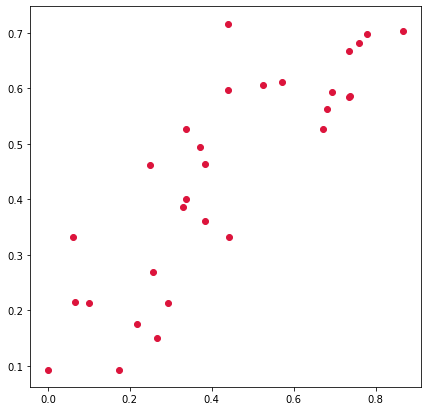

In [49]:
XGModel = XGBRegressor(random_state = 1,
                        reg_alpha = 0,
                        colsample_bytree = 0.5,
                        eta = 0.1,
                        max_depth = 4,
                        min_child_weight =4,
                        max_delta_step = 0,
                        gamma = 0,
                        reg_lambda = 2,
                        tree_method = 'auto',
                        subsample = 1)
modelEvaluation(XGModel, 'XGModel')

In [ ]:
XGModel = XGBRegressor()
modelEvaluation(XGModel, 'XGModel')

In [ ]:
extraTreeModel = ExtraTreesRegressor(n_estimators=1600, min_samples_split=2,min_samples_leaf=1, max_features='sqrt', max_depth=30, bootstrap=True)
modelEvaluation(extraTreeModel, 'Extra Trees model')

In [ ]:
RFModel = RandomForestRegressor(n_estimators=600,min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=100, bootstrap=True)
modelEvaluation(RFModel, 'Random Forest Model')

# 🚨 TSR Effect and Shap values

In [6]:
dfTSREffect = returnDf('TSREffect')

In [7]:
dfTSREffectNoOutliers = eliminateOutliers(dfTSREffect, 'Effect(%)')

Initial dataframe size: (106, 37)
Final dataframe size: (106, 37)


In [8]:
dfTSREffectNoOutliers['Virgin Bitumen Penetration'] = pd.to_numeric(dfTSREffectNoOutliers['Virgin Bitumen Penetration'])

In [9]:
dfTSREffectNoOutliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 1 to 140
Data columns (total 37 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Article ID                              106 non-null    object 
 1   Global ID                               106 non-null    object 
 2   Modified asphalt Mix?                   106 non-null    object 
 3   Agreggate Type                          62 non-null     object 
 4   Aggregate absorption (%)                77 non-null     float64
 5   Apparent specific gravity               23 non-null     float64
 6   0.075                                   101 non-null    float64
 7   0.3                                     101 non-null    float64
 8   0.6                                     104 non-null    float64
 9   2.36                                    104 non-null    float64
 10  4.75                                    104 non-null    float6

## 🛀 Data Preprocessing

In [11]:
#Categorical Variables
dfTSREffectNoOutliers = dfTSREffectNoOutliers.drop(['Article ID', 
                                    'Global ID',
                                    'Modified asphalt Mix?',
                                    'Agreggate Type', 
                                    'Apparent specific gravity', 
                                    'Filler used', 
                                    'Bitumen Type Penetration Grade', 
                                    'Property', 
                                    'Units', 
                                    'Plastic Size',
                                    'Consolidated bitumen penetration grade' ], axis = 1)
dfTSREffectNoOutliers = dfTSREffectNoOutliers.dropna(subset=['New Plastic Type'])
dfTSREffectNoOutliers = pd.get_dummies(dfTSREffectNoOutliers, columns=['New Plastic Type'], drop_first=True)
dfTSREffectNoOutliers = pd.get_dummies(dfTSREffectNoOutliers, drop_first=True)

In [12]:
dfTSREffectNoOutliers

,Aggregate absorption (%),0.075,0.3,0.6,2.36,4.75,9.5,12.5,19,Virgin Bitumen Penetration,Plastic particle size (mm),Mixing speed (RPM),Mixing Temperature,Mixing Time (hours),Plastic Addition by bitumen weight (%),Bitumen content in the sample,TSR Control[%],TSR of the sample[%],Effect(%),New Plastic Type_PET,New Plastic Type_PP,New Plastic Type_PS,New Plastic Type_Plastic Mix,Plastic pretreatment_Plastic Melted,Plastic shape_Pellets,Plastic shape_Shredded,Mixing Process_Wet,Aggregates replacement ?_Yes,Bitumen replacement?_Yes
TSREffect ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.70,4.46,12.41,39.16,53.13,68.67,96.87,100.00,100.00,40.0,6.35,0.0,0.0,0.0,5.072464,6.70,72.39,87.06,-0.202652,0,0,1,0,0,0,0,0,0,0
4,0.70,4.46,12.41,39.16,53.13,68.67,96.87,100.00,100.00,40.0,12.70,0.0,0.0,0.0,6.849315,6.70,72.39,87.31,-0.206106,0,0,1,0,0,0,0,0,0,0
3,0.70,4.46,12.41,39.16,53.13,68.67,96.87,100.00,100.00,40.0,12.70,0.0,0.0,0.0,4.929577,6.70,72.39,89.30,-0.233596,0,0,1,0,0,0,0,0,0,0
9,0.50,5.42,11.93,33.01,51.08,71.08,92.05,100.00,100.00,40.0,6.35,0.0,0.0,0.0,4.861111,6.20,66.17,89.55,-0.353332,0,0,1,0,0,0,0,0,0,0
5,0.80,5.06,13.25,33.01,54.10,67.59,96.87,100.00,100.00,40.0,6.35,0.0,0.0,0.0,5.468750,5.90,68.16,90.55,-0.328492,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,0.95,2.86,7.03,11.46,30.73,43.88,79.95,92.06,99.87,66.0,NaN,0.0,0.0,0.0,9.000000,4.30,84.99,89.04,-0.047653,0,0,0,0,0,0,1,0,0,0
136,0.95,2.86,7.03,11.46,30.73,43.88,79.95,92.06,99.87,66.0,NaN,0.0,0.0,0.0,9.000000,4.30,84.99,92.06,-0.083186,0,0,0,0,0,0,1,0,0,0
137,1.07,2.86,7.03,11.46,30.73,43.88,79.95,92.06,99.87,66.0,NaN,0.0,0.0,0.0,9.000000,4.28,83.07,92.06,-0.108222,0,0,0,0,0,0,1,0,0,0


In [13]:
# Split X and Y
X = dfTSREffectNoOutliers[dfTSREffectNoOutliers.columns.difference(['Effect(%)','TSR Control[%]', 'TSR of the sample[%]'])]
y = dfTSREffectNoOutliers[['Effect(%)']]
X.head()

,0.075,0.3,0.6,2.36,4.75,9.5,12.5,19,Aggregate absorption (%),Aggregates replacement ?_Yes,Bitumen content in the sample,Bitumen replacement?_Yes,Mixing Process_Wet,Mixing Temperature,Mixing Time (hours),Mixing speed (RPM),New Plastic Type_PET,New Plastic Type_PP,New Plastic Type_PS,New Plastic Type_Plastic Mix,Plastic Addition by bitumen weight (%),Plastic particle size (mm),Plastic pretreatment_Plastic Melted,Plastic shape_Pellets,Plastic shape_Shredded,Virgin Bitumen Penetration
TSREffect ID,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.46,12.41,39.16,53.13,68.67,96.87,100.0,100.0,0.7,0,6.7,0,0,0.0,0.0,0.0,0,0,1,0,5.072464,6.35,0,0,0,40.0
4,4.46,12.41,39.16,53.13,68.67,96.87,100.0,100.0,0.7,0,6.7,0,0,0.0,0.0,0.0,0,0,1,0,6.849315,12.70,0,0,0,40.0
3,4.46,12.41,39.16,53.13,68.67,96.87,100.0,100.0,0.7,0,6.7,0,0,0.0,0.0,0.0,0,0,1,0,4.929577,12.70,0,0,0,40.0
9,5.42,11.93,33.01,51.08,71.08,92.05,100.0,100.0,0.5,0,6.2,0,0,0.0,0.0,0.0,0,0,1,0,4.861111,6.35,0,0,0,40.0
5,5.06,13.25,33.01,54.10,67.59,96.87,100.0,100.0,0.8,0,5.9,0,0,0.0,0.0,0.0,0,0,1,0,5.468750,6.35,0,0,0,40.0


In [14]:
#IMPUTATION OF MISSING VALUES
imputer = IterativeImputer (estimator = ExtraTreesRegressor(n_estimators=10, random_state = 123), max_iter=50,random_state = 123)
n = imputer.fit_transform(X)
X_Imputed = pd.DataFrame(n, columns = list(X.columns))
print ('There is '+ 
str(sum(n < 0 for n in X_Imputed.loc[:,X_Imputed.columns].values.flatten()))+
' negative values in the new DataFrame')

There is 0 negative values in the new DataFrame


In [15]:
X_Imputed['New Plastic Type_PET'] = X_Imputed['New Plastic Type_PET'] * X_Imputed['Plastic Addition by bitumen weight (%)']
X_Imputed['New Plastic Type_PP'] = X_Imputed['New Plastic Type_PP'] * X_Imputed['Plastic Addition by bitumen weight (%)']
X_Imputed['New Plastic Type_PS'] = X_Imputed['New Plastic Type_PS'] * X_Imputed['Plastic Addition by bitumen weight (%)']
X_Imputed['New Plastic Type_Plastic Mix'] = X_Imputed['New Plastic Type_Plastic Mix'] * X_Imputed['Plastic Addition by bitumen weight (%)']
X_Imputed = X_Imputed.drop(['Plastic Addition by bitumen weight (%)' ], axis = 1)

In [17]:
# Scaling
 #Feature Scaling
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X_Imputed), columns = list(X_Imputed))
X.head()

,0.075,0.3,0.6,2.36,4.75,9.5,12.5,19,Aggregate absorption (%),Aggregates replacement ?_Yes,Bitumen content in the sample,Bitumen replacement?_Yes,Mixing Process_Wet,Mixing Temperature,Mixing Time (hours),Mixing speed (RPM),New Plastic Type_PET,New Plastic Type_PP,New Plastic Type_PS,New Plastic Type_Plastic Mix,Plastic particle size (mm),Plastic pretreatment_Plastic Melted,Plastic shape_Pellets,Plastic shape_Shredded,Virgin Bitumen Penetration
0,0.260586,0.340076,1.000000,0.971554,0.948811,1.000000,1.0,0.998715,0.204082,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.220542,0.0,0.121730,0.0,0.0,0.0,0.0
1,0.260586,0.340076,1.000000,0.971554,0.948811,1.000000,1.0,0.998715,0.204082,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.297796,0.0,0.249497,0.0,0.0,0.0,0.0
2,0.260586,0.340076,1.000000,0.971554,0.948811,1.000000,1.0,0.998715,0.204082,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.214329,0.0,0.249497,0.0,0.0,0.0,0.0
3,0.416938,0.309735,0.788587,0.911437,1.000000,0.903349,1.0,0.998715,0.136054,0.0,0.886079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.211353,0.0,0.121730,0.0,0.0,0.0,0.0
4,0.358306,0.393173,0.788587,1.000000,0.925871,1.000000,1.0,0.998715,0.238095,0.0,0.817726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.237772,0.0,0.121730,0.0,0.0,0.0,0.0


## 🧠Model Training

In [18]:
cv = RepeatedKFold(n_splits = 10, n_repeats = 10, random_state = 123)
scores = cross_validate(XGBRegressor(random_state=123, n_estimators=500), X, y, cv=cv,scoring=('r2', 'neg_mean_squared_error'),return_train_score=True)
np.average(scores['test_r2'])b

0.6327798467368745

## 🔪SHAP Values

In [19]:
import shap

In [20]:
model = XGBRegressor().fit(X, y)
explainer = shap.Explainer(model)
shap_values = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


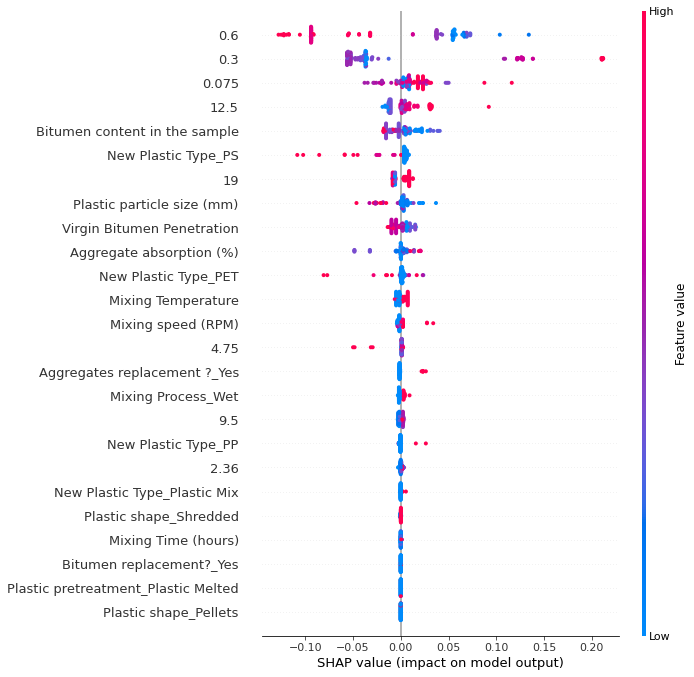

In [21]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=28)

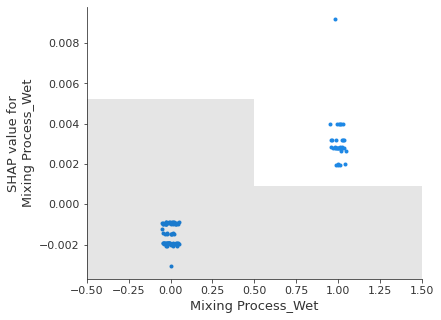

In [22]:
shap.plots.scatter(shap_values[:,'Mixing Process_Wet'])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


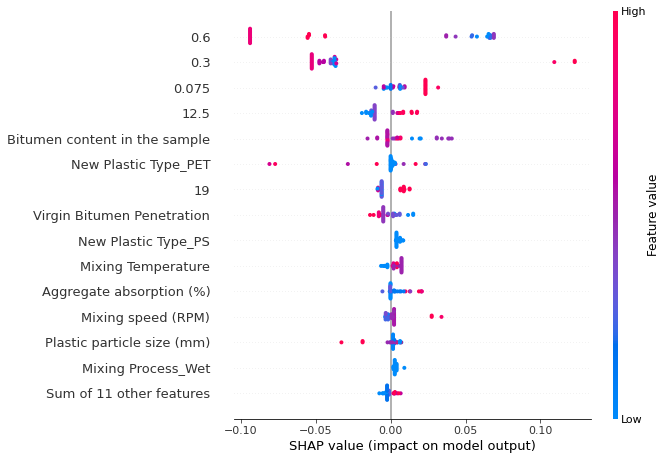

In [23]:
shap_values_wet = explainer(X[X['Mixing Process_Wet'] == 1])
# summarize the effects of all the features
shap.plots.beeswarm(shap_values_wet, max_display=15)

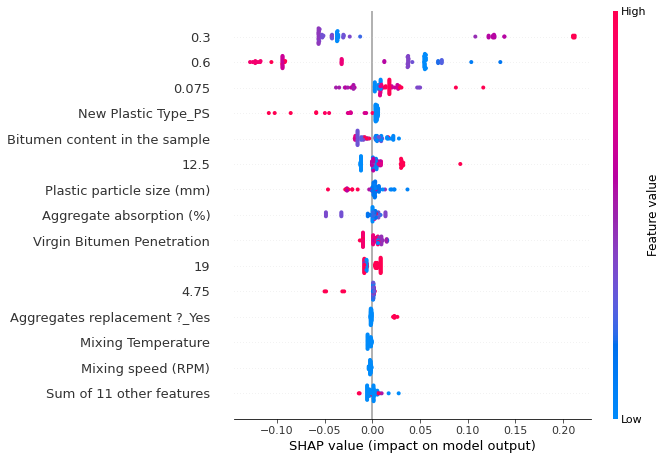

In [24]:
shap_values_dry = explainer(X[X['Mixing Process_Wet'] == 0])
# summarize the effects of all the features
shap.plots.beeswarm(shap_values_dry, max_display=15)